In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
frameObjTrain = {'sketch' : [], 'color' : []}
frameObjTest = {'sketch' : [], 'color' : []}


## defining data Loader function
def LoadData( frameObj = None, sketchPath = None, colorPath = None, shape = 256, num=20):
    sketchNames = os.listdir(sketchPath)[0:num]
    colorNames = os.listdir(colorPath)[0:num]
    
    sketchAddr = sketchPath + '/'
    colorAddr = colorPath + '/'
    
    for i in tqdm (range (len(sketchNames))):
        sketch = plt.imread(sketchAddr + sketchNames[i])
        sketch = cv2.resize(sketch, (shape, shape)) 
        frameObj['sketch'].append(sketch[:,:,0])
        
    for i in  tqdm (range (len(colorNames))):
        color = plt.imread(colorAddr + colorNames[i])
        color = cv2.resize(color, (shape, shape))
        
        if len(color.shape) > 2 and color.shape[2] == 4:
            #convert the image from RGBA2RGB
            color = cv2.cvtColor(color, cv2.COLOR_BGRA2BGR)
        
        frameObj['color'].append(color)

    return frameObj

In [4]:
framObjTrain = LoadData( frameObjTrain, sketchPath = 'preprocessed_data/train/sketches'
                        , colorPath = 'preprocessed_data/train/colors'
                         , shape = 256, num=3000)

framObjTest = LoadData( frameObjTest, sketchPath = 'preprocessed_data/test/sketches'
                        , colorPath = 'preprocessed_data/test/colors'
                         , shape = 256, num=100)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.25it/s]


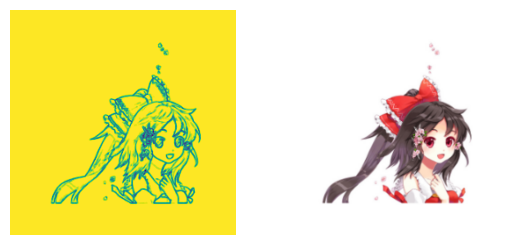

In [5]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['sketch'][1])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['color'][1])
plt.axis('off')
plt.show()

In [6]:
framObjTrain['color'][1].shape

(256, 256, 3)

In [7]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


def Unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [8]:
inputs = tf.keras.layers.Input((256, 256, 1))
model = Unet(inputs, droupouts= 0.07)
model.compile(optimizer = 'Adam', loss = tf.compat.v1.losses.mean_pairwise_squared_error, metrics = ['accuracy'] )

In [9]:
results = model.fit(np.array(frameObjTrain['sketch']), np.array(frameObjTrain['color']), epochs = 40, verbose = 1)

Epoch 1/40
94/94 [==============================] - 56s 485ms/step - loss: 1.2963 - accuracy: 0.4624
Epoch 2/40
94/94 [==============================] - 41s 440ms/step - loss: 1.0000 - accuracy: 0.4664
Epoch 3/40
94/94 [==============================] - 41s 440ms/step - loss: 0.9490 - accuracy: 0.4771
Epoch 4/40
94/94 [==============================] - 41s 440ms/step - loss: 0.9138 - accuracy: 0.4600
Epoch 5/40
94/94 [==============================] - 41s 441ms/step - loss: 0.8856 - accuracy: 0.4559
Epoch 6/40
94/94 [==============================] - 42s 442ms/step - loss: 0.8679 - accuracy: 0.4134
Epoch 7/40
94/94 [==============================] - 42s 442ms/step - loss: 0.8435 - accuracy: 0.4230
Epoch 8/40
94/94 [==============================] - 42s 442ms/step - loss: 0.8326 - accuracy: 0.4361
Epoch 9/40
94/94 [==============================] - 41s 441ms/step - loss: 0.8093 - accuracy: 0.4160
Epoch 10/40
94/94 [==============================] - 41s 441ms/step - loss: 0.8018 - accura

INFO:tensorflow:Assets written to: saved_model/model_v2\assets


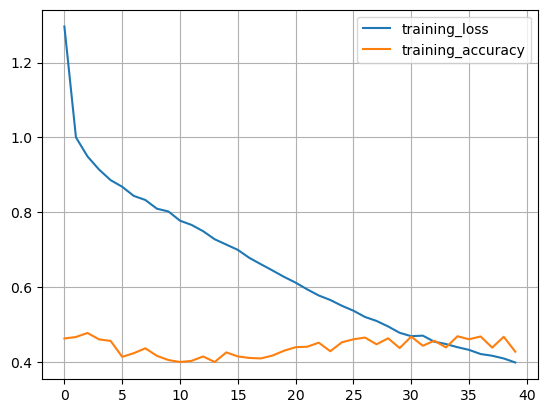

In [10]:
model.save('saved_model/model_v2')

plt.plot(results.history['loss'], label = 'training_loss')
plt.plot(results.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [11]:
def predict(testMap, model, shape = 256):
    ## getting and proccessing val data
    sketch = testMap['sketch']
    color = testMap['color']
    color = color
    
    sketchProc = sketch
    sketchProc = np.array(sketch)
    
    predictions = model.predict(sketchProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, sketchProc, color


def Plotter(sketch, predColor, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(sketch, cmap = 'gray')
    plt.title('Grey scale')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(predColor)

    plt.title('Predicted colored')
    plt.axis('off')

    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual colored')
    plt.axis('off')


In [12]:
# model = tf.keras.models.load_model('saved_model/model_v2')
prediction, sketchs, colors = predict(frameObjTest, model)

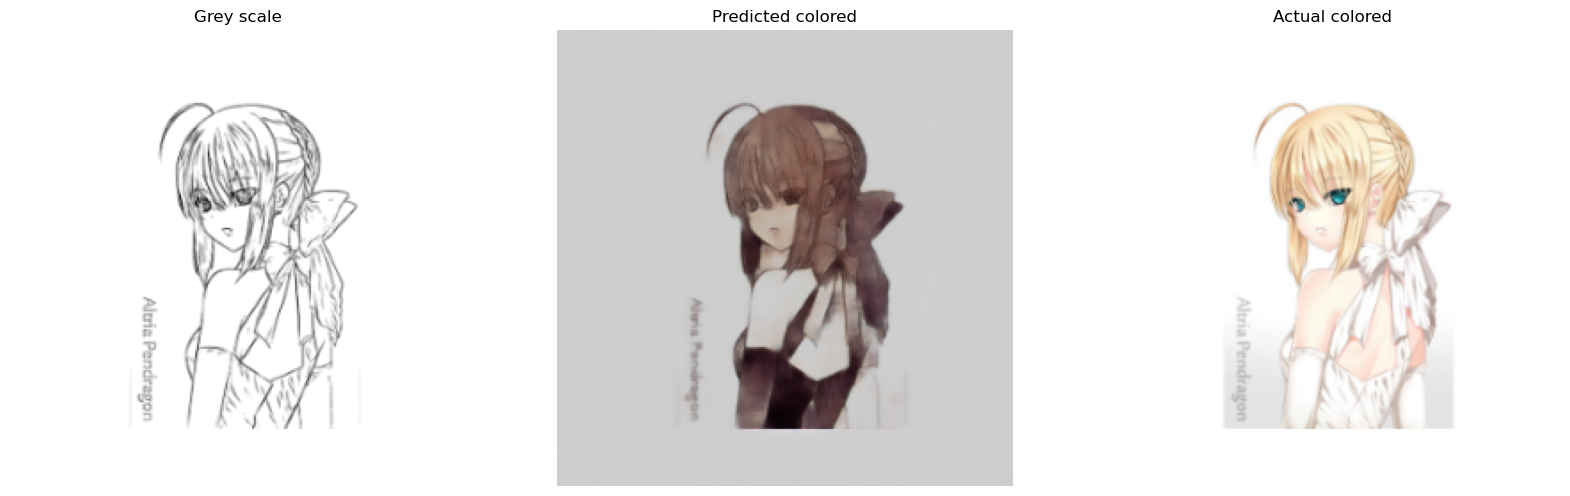

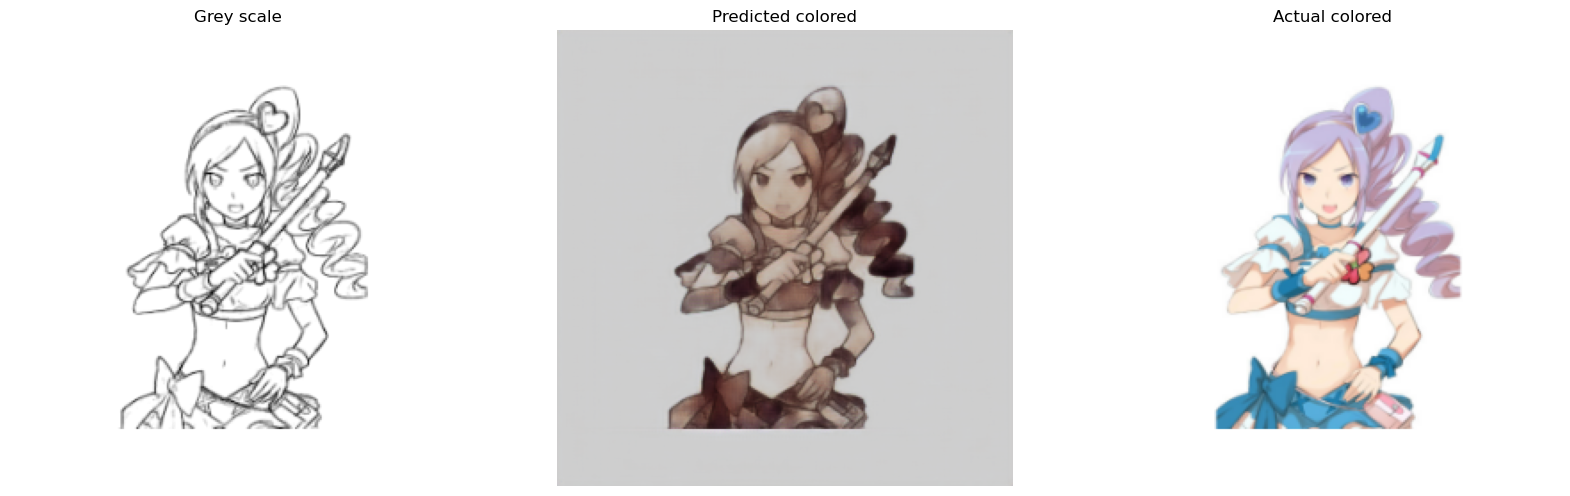

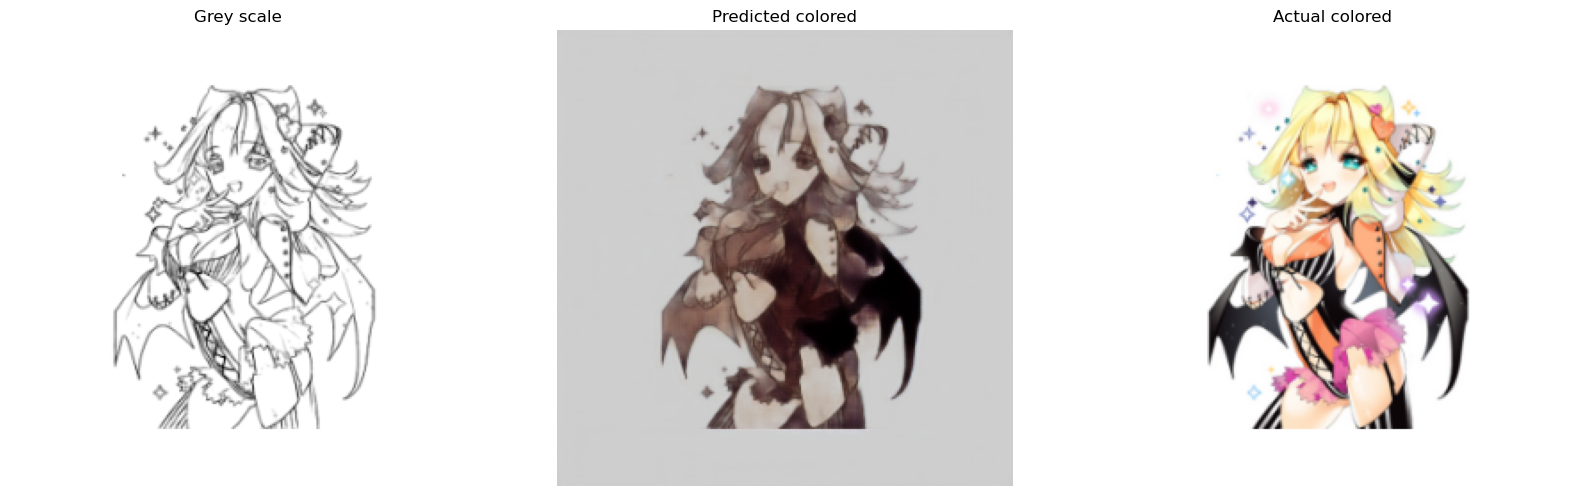

In [13]:
Plotter(sketchs[3], prediction[3], colors[3])
Plotter(sketchs[16], prediction[16], colors[16])
Plotter(sketchs[19], prediction[19], colors[19])

In [22]:
sketch_test = frameObjTest['sketch']
color_test = frameObjTest['color']

sketchProc = np.array(sketch_test)
colorProc = np.array(color_test)

results = model.evaluate(sketchProc, colorProc)
print("Test loss, Test acc:", results)

4/4 [==============================] - 1s 88ms/step - loss: 0.8398 - accuracy: 0.3053
Test loss, Test acc: [0.8397533297538757, 0.3052677810192108]
